
<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020


* Daury Lecca
* Nicolas Lema
* Alejandro Martínez
* David Ortiz


**1. Instalación de librerias a utilizar**

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install contractions
!pip install feedparser
!pip install newspaper3k
!pip install pandas_profiling
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport


import nltk
import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve

import matplotlib.pyplot as plt

In [3]:
import json

**2. Perfilamiento y entendimiento de los datos**



* Lectura de los datos

A continuación procedemos a leer los datos del Dataset de Kaggle, los cuales ya estan dividos entre Fake news y Real News.

Despues te esto, hacemos un proceso de web scrapping de diferentes medios que tienen noticias reales y falsas para aumentar el tamaño de la muestra y la diversidad de noticias de nuestro dataSet y tener noticias de un contexto mas actual ya que las del dataset de kaggle estan en un periodo comprendido entre 2016 y 2018

In [4]:
def get_data(dataset):
    if(dataset=='true'):
        url = 'https://raw.githubusercontent.com/alejitro/proyecto_MLT_Grupo05/master/DataSet/True.csv'
        return pd.read_csv(url,error_bad_lines=True)
    elif(dataset=='false'):
        url = 'https://raw.githubusercontent.com/alejitro/proyecto_MLT_Grupo05/master/DataSet/Fake.csv'
        return pd.read_csv(url,error_bad_lines=True)
    else:
        return ("No data")

* Medios de los cuales se van a obtener noticias recientes:

In [8]:
dictionary = {
  "bbc": {
    "rss": "http://feeds.bbci.co.uk/news/rss.xml",
    "link": "http://www.bbc.com/"
  },
  "theguardian": {
    "rss": "https://www.theguardian.com/uk/rss",
    "link": "https://www.theguardian.com/international"
  },
  "breitbart": {
    "link": "http://www.breitbart.com/"
  },
  "infowars": {
    "link": "https://www.infowars.com/"
  },
  "washingtonpost": {
    "rss": "http://feeds.washingtonpost.com/rss/world",
    "link": "https://www.washingtonpost.com/"
  },
  "theonion": {
    "link": "http://www.theonion.com/"
  }
}

In [13]:
json_object = json.dumps(dictionary, indent = 4) 
with open("NewsPapers.json", "w") as outfile: 
    outfile.write(json_object) 

* Codigo para importar las noticias en un archivo JSON

En el codigo tenemos la opcion de variar el numero de articulos de cada medio que se quieren descargar (variable LIMIT), esto nos permite mantener el balance del dataset entre las noticias verdaderas y falsas.

En esta iteracion, con el fin de poder hacer el entendimiento de los datos de una forma rapida, solo tomamos 5 articulos adicionales por cada medio, en la siguiente iteración, tomaremos un numero mayor para aumentar el tamaño del dataset y asi mismo la calidad de instancias para poder determinar las clases.

In [10]:
import feedparser as fp
import json
import newspaper
from newspaper import Article
from time import mktime
from datetime import datetime

# Set the limit for number of articles to download
#LIMIT = 14500
LIMIT = 5

data = {}
data['newspapers'] = {}

# Loads the JSON files with news sites
with open('NewsPapers.json') as data_file:
    companies = json.load(data_file)

count = 1

# Iterate through each news company
for company, value in companies.items():
    # If a RSS link is provided in the JSON file, this will be the first choice.
    # Reason for this is that, RSS feeds often give more consistent and correct data.
    # If you do not want to scrape from the RSS-feed, just leave the RSS attr empty in the JSON file.
    if 'rss' in value:
        d = fp.parse(value['rss'])
        print("Downloading articles from ", company)
        newsPaper = {
            "rss": value['rss'],
            "link": value['link'],
            "articles": []
        }
        for entry in d.entries:
            # Check if publish date is provided, if no the article is skipped.
            # This is done to keep consistency in the data and to keep the script from crashing.
            if hasattr(entry, 'published'):
                if count > LIMIT:
                    break
                article = {}
                article['link'] = entry.link
                date = entry.published_parsed
                article['published'] = datetime.fromtimestamp(mktime(date)).isoformat()
                try:
                    content = Article(entry.link)
                    content.download()
                    content.parse()
                except Exception as e:
                    # If the download for some reason fails (ex. 404) the script will continue downloading
                    # the next article.
                    print(e)
                    print("continuing...")
                    continue
                article['title'] = content.title
                article['text'] = content.text
                newsPaper['articles'].append(article)
                print(count, "articles downloaded from", company, ", url: ", entry.link)
                count = count + 1
    else:
        # This is the fallback method if a RSS-feed link is not provided.
        # It uses the python newspaper library to extract articles
        print("Building site for ", company)
        paper = newspaper.build(value['link'], memoize_articles=False)
        newsPaper = {
            "link": value['link'],
            "articles": []
        }
        noneTypeCount = 0
        for content in paper.articles:
            if count > LIMIT:
                break
            try:
                content.download()
                content.parse()
            except Exception as e:
                print(e)
                print("continuing...")
                continue
            # Again, for consistency, if there is no found publish date the article will be skipped.
            # After 10 downloaded articles from the same newspaper without publish date, the company will be skipped.
            if content.publish_date is None:
                print(count, " Article has date of type None...")
                noneTypeCount = noneTypeCount + 1
                if noneTypeCount > 100:
                    print("Too many noneType dates, aborting...")
                    noneTypeCount = 0
                    break
                count = count + 1
                continue
            article = {}
            article['title'] = content.title
            article['text'] = content.text
            article['link'] = content.url
            article['published'] = content.publish_date.isoformat()
            newsPaper['articles'].append(article)
            print(count, "articles downloaded from", company, " using newspaper, url: ", content.url)
            count = count + 1
            noneTypeCount = 0
    count = 1
    data['newspapers'][company] = newsPaper

# Finally it saves the articles as a JSON-file.
try:
    with open('scraped_articles.json', 'w') as outfile:
        json.dump(data, outfile)
except Exception as e: print(e)

1 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/uk-england-hereford-worcester-53381802
2 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/world-us-canada-53382540
Article `download()` failed with HTTPSConnectionPool(host='www.bbc.co.uk', port=443): Read timed out. (read timeout=7) on URL https://www.bbc.co.uk/news/world-africa-53382797
continuing...
Article `download()` failed with HTTPSConnectionPool(host='www.bbc.co.uk', port=443): Read timed out. (read timeout=7) on URL https://www.bbc.co.uk/news/uk-53381000
continuing...
3 articles downloaded from bbc , url:  https://www.bbc.co.uk/sport/football/53381586
Article `download()` failed with ('Connection aborted.', OSError(0, 'Error')) on URL https://www.bbc.co.uk/news/world-europe-53385021
continuing...
4 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/uk-53382563
5 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/business-53380719
1 articles downloaded from theguardian , 

In [14]:
with open('scraped_articles.json') as json_data:
    d = json.load(json_data)

In [15]:
for i, site in enumerate((list(d['newspapers']))):
    print(i, site)

0 bbc
1 theguardian
2 breitbart
3 infowars
4 foxnews
5 nbcnews
6 washingtonpost
7 theonion


Hacemos un pandas dataFrame con los articulos descargados

In [16]:
for i, site in enumerate((list(d['newspapers']))):
    articles = list(d['newspapers'][site]['articles'])
    if i == 0:
        df = pd.DataFrame.from_dict(articles)
        df["site"] = site
    else:
        new_df = pd.DataFrame.from_dict(articles)
        new_df["site"] = site
        df = pd.concat([df, new_df], ignore_index = True)     

Leemos los datos provenientes del dataset de Kaggle

In [18]:
true_data=get_data('true')
fake_data=get_data('false')

Le asignamos la categoria correspondiente a cada uno de los dataframes y lo unimos en uno solo.

In [22]:
true_data['category']= 'True'
fake_data['category']= 'Fake'

df_news = pd.concat([true_data, fake_data])
df_news.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44867 entries, 0 to 23449
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44867 non-null  object
 1   text      44867 non-null  object
 2   subject   44867 non-null  object
 3   date      44867 non-null  object
 4   category  44867 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


Hacemos la categorización en el dataset proveniente del scrappping.

In [23]:
data=df.drop(['link'], axis=1)
data['site']=data['site'].replace(['bbc','cnn','theguardian', 'foxnews','nbcnews','washingtonpost'
                                  ,'breitbart','infowars','theonion'], 
                                  ['True','True','True','True','True','True',
                                   'Fake','Fake','Fake'])

Eliminamos la columna subject ya que consideramos que esta no aporta información significativa para la resolución del problema

In [48]:
df_news=df_news.drop(['subject'], axis=1)
df_news.head()

,title,text,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,2017-12-31,True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,2017-12-29,True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,2017-12-31,True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,2017-12-30,True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,2017-12-29,True


Reemplazamos los nombres en las columnas del dataframe proveniente del web scrapping con el fin de poder unirlo con el dataset existente de kaggle

In [25]:
data.rename(columns={'published':'date',                           
                    'site':'category'},
                    inplace=True)
df_news['date']=df_news['date'].apply(pd.to_datetime)
data['date']=data['date'].apply(pd.to_datetime)

In [26]:
total_news_df = pd.concat([df_news, data])

In [32]:
total_news_df=total_news_df.drop(['subject'], axis=1)
total_news_df.head()

,title,text,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,2017-12-31 00:00:00,True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,2017-12-29 00:00:00,True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,2017-12-31 00:00:00,True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,2017-12-30 00:00:00,True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,2017-12-29 00:00:00,True


Verificamos el numero de columnas del dataset final y que este no tenga datos nulos.

In [34]:
total_news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44891 entries, 0 to 23
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44891 non-null  object
 1   text      44891 non-null  object
 2   date      44891 non-null  object
 3   category  44891 non-null  object
dtypes: object(4)
memory usage: 3.0+ MB


### 3. Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Eliminación del Ruido.
* Tokenización.
* Normalización.

In [36]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

Procedemos a ejecutar las funciones de eliminación de ruido y tokenización de palabras

In [37]:
total_news_df['text'] = total_news_df['text'].apply(contractions.fix) #Aplica la corrección de las contracciones
total_news_df['words'] = total_news_df['text'].apply(word_tokenize)
total_news_df['words'] = total_news_df['words'].apply(preproccesing) #Aplica la eliminación del ruido
total_news_df.head()

,title,text,date,category,words
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,2017-12-31 00:00:00,True,"[washington, reuters, head, conservative, repu..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,2017-12-29 00:00:00,True,"[washington, reuters, transgender, people, all..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,2017-12-31 00:00:00,True,"[washington, reuters, special, counsel, invest..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,2017-12-30 00:00:00,True,"[washington, reuters, trump, campaign, adviser..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,2017-12-29 00:00:00,True,"[seattlewashington, reuters, president, donald..."


**Separacion de datos según categoría**

Separamos los datos según su categoría con el fin de hacer análisis de los datos para el entendimiento del problema

In [ ]:
fake=total_news_df[total_news_df['category']=='Fake']
true=total_news_df[total_news_df['category']=='True']

In [ ]:
import ipywidgets as widgets
from IPython import display
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(fake.head(5))
with widget2:
    display.display(true.head(5))

# create HBox
hbox = widgets.HBox([widget1, widget2])

# render hbox
hbox

Una vez hacemos la limpieza de los datos, la eliminación de ruido y la tokenización de los datos procedemos a hacer el analisis de el numero de palabras en los titulos y textos de cada categoría.

**Entendimiento de textos de las noticias**

In [189]:
import statistics
words_per_article_plot_t = true["text"].apply(lambda x: len(x.split()))
stdev_t = statistics.stdev(words_per_article_plot_t)
words_per_article_t = words_per_article_plot_t.sum()/len(true["text"])

words_per_article_plot_f = fake["text"].apply(lambda x: len(x.split()))
stdev_f = statistics.stdev(words_per_article_plot_f)
words_per_article_f = words_per_article_plot_f.sum()/len(fake["text"])

print ("The average number of words in a real news article is ", words_per_article_t)
print ("The average number of words in a fake news article is ", words_per_article_f)

print ("The standard deviation in real news article lengths is ", stdev_t)
print ("The standard deviation in fake news article lengths is ", stdev_f)

The average number of words in a real news article is  385.9079413960433
The average number of words in a fake news article is  417.8937675846193
The standard deviation in real news article lengths is  274.26116659601513
The standard deviation in fake news article lengths is  364.19202053868975


Text(0.5, 1.0, 'Numero de palabras en articulos de noticias falsas')

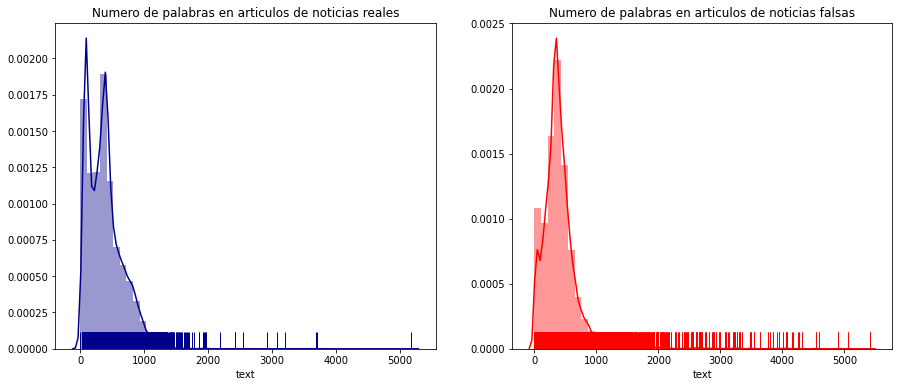

In [190]:
import seaborn as sns
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(words_per_article_plot_t, ax = ax[0], color = "darkblue", rug = True).set_title("Numero de palabras en articulos de noticias reales")
sns.distplot(words_per_article_plot_f, ax = ax[1], color = "red", rug = True).set_title("Numero de palabras en articulos de noticias falsas")

En este primer analisis quisimos observar si el número de palabras del articulo tiene alguna relación con la categoría de la noticia, efectivamente encontramos que las fake news tienden <br/>  a ser mas largas que las noticias reales

**Entendimiento de titulos de las noticias**

In [188]:
words_per_headline_plot_t = true["title"].apply(lambda x: len(x.split()))
stdev_t_head = statistics.stdev(words_per_headline_plot_t)
words_per_headline_t = words_per_headline_plot_t.sum()/len(true["title"])

words_per_headline_plot_f = fake["title"].apply(lambda x: len(x.split()))
stdev_f_head = statistics.stdev(words_per_headline_plot_f)
words_per_headline_f = words_per_headline_plot_f.sum()/len(fake["title"])

print ("The average number of words in a real news article is ", words_per_headline_t)
print ("The average number of words in a fake news article is ", words_per_headline_f)

print ("The standard deviation in real news article lengths is ", stdev_t_head)
print ("The standard deviation in fake news article lengths is ", stdev_f_head)

The average number of words in a real news article is  9.954973870847331
The average number of words in a fake news article is  14.739150822747037
The standard deviation in real news article lengths is  1.7020293791617223
The standard deviation in fake news article lengths is  4.3270646228334115


Text(0.5, 1.0, 'Number of Words in Fake News Headline')

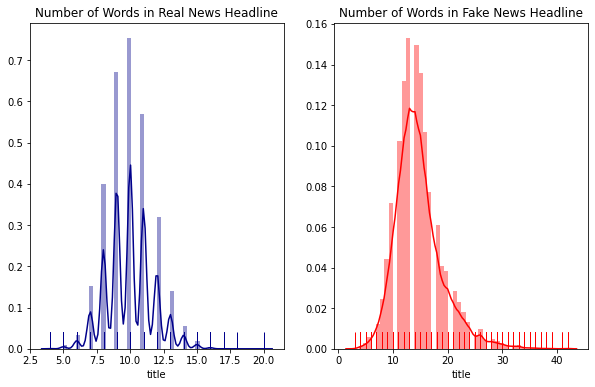

In [186]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(words_per_headline_plot_t, ax = ax[0], color = "darkblue", rug = True).set_title("Number of Words in Real News Headline")
sns.distplot(words_per_headline_plot_f, ax = ax[1], color = "red", rug = True).set_title("Number of Words in Fake News Headline")

En este analisis quisimos observar si el número de palabras del título tiene alguna relación con la categoría de la noticia, efectivamente encontramos que los títulos de las  <br/> fake news tienden a ser mas largos que los de las noticias reales

#### **Normalización**
Para la normalización de los datos se realiza una eliminación de prefijos y sufijos, además de realizar una lemmatización de los verbos.

In [41]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

total_news_df['words'] = total_news_df['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
total_news_df.head()

,title,text,date,category,words
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,2017-12-31 00:00:00,True,"[washington, reut, head, conserv, republ, fact..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,2017-12-29 00:00:00,True,"[washington, reut, transgend, peopl, allow, fi..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,2017-12-31 00:00:00,True,"[washington, reut, spec, counsel, investig, li..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,2017-12-30 00:00:00,True,"[washington, reut, trump, campaign, adv, georg..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,2017-12-29 00:00:00,True,"[seattlewashington, reut, presid, donald, trum..."


Por ultimo convertimos la columna que contiene el arreglo de palabras, de una lista a una cadena de caracteres para la posterior manipulación de los mismos al hacer la preparación de los datos para el modelo.

In [42]:
total_news_df['words'] = total_news_df['words'].apply(lambda x: ' '.join(map(str, x)))
total_news_df

,title,text,date,category,words
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,2017-12-31 00:00:00,True,washington reut head conserv republ fact yo co...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,2017-12-29 00:00:00,True,washington reut transgend peopl allow first ti...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,2017-12-31 00:00:00,True,washington reut spec counsel investig link rus...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,2017-12-30 00:00:00,True,washington reut trump campaign adv georg papad...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,2017-12-29 00:00:00,True,seattlewashington reut presid donald trump cal...
...,...,...,...,...,...
19,"Within the Taliban, clashing views of Afghanis...","MARAWARA, Afghanistan — In talks in Doha and i...",2020-07-12 07:30:20,True,marawar afgh talk doh kab talib lead struck co...
20,Misaligned radar responsible for downing of Uk...,Most of the dead were Iranian; 85 had citizens...,2020-07-12 06:49:00,True,dead ir eightyf cit perm resid canad many stud...
21,Bolsonaro coronavirus: Brazil’s president defi...,"RIO DE JANEIRO — For months, even as the coron...",2020-07-11 16:12:59,True,rio de janeiro month ev coronavir pandem grew ...
22,Polish President Duda and challenger Trzaskows...,But a victory by the centrist opposition would...,2020-07-12 09:25:00,True,vict cent opposit would mark stun chang pol po...
